# Import data

In [2]:
import pandas as pd

data = pd.read_csv("../single_parameter/combined_data/statistics.csv")
data.head()

,RunId,TargetModule,Algorithm,AlgorithmIterations,SearchTime,TuningParameters,Coverage,CoverageTimeline_T1,CoverageTimeline_T2,CoverageTimeline_T3,...,CoverageTimeline_T291,CoverageTimeline_T292,CoverageTimeline_T293,CoverageTimeline_T294,CoverageTimeline_T295,CoverageTimeline_T296,CoverageTimeline_T297,CoverageTimeline_T298,CoverageTimeline_T299,CoverageTimeline_T300
0,flutils.decorators#247,flutils.decorators,DYNAMOSA_RL,1513,300064136954,TestChangeProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
1,codetiming._timer#100,codetiming._timer,DYNAMOSA_RL,1001,300064143210,Elite,0.888889,0.555556,0.555556,0.629630,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
2,codetiming._timer#222,codetiming._timer,DYNAMOSA_RL,1516,300085846117,StatementInsertionProbability,0.888889,0.444444,0.666667,0.696566,...,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889,0.888889
3,flutils.decorators#327,flutils.decorators,DYNAMOSA_RL,1510,300133832198,TestInsertProbability,0.666667,0.666667,0.666667,0.666667,...,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,httpie.output.formatters.headers#50,httpie.output.formatters.headers,DYNAMOSA_RL,2089,300206714135,ChromosomeLength,0.600000,0.600000,0.600000,0.600000,...,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000,0.600000


# Coverage Distribution plot

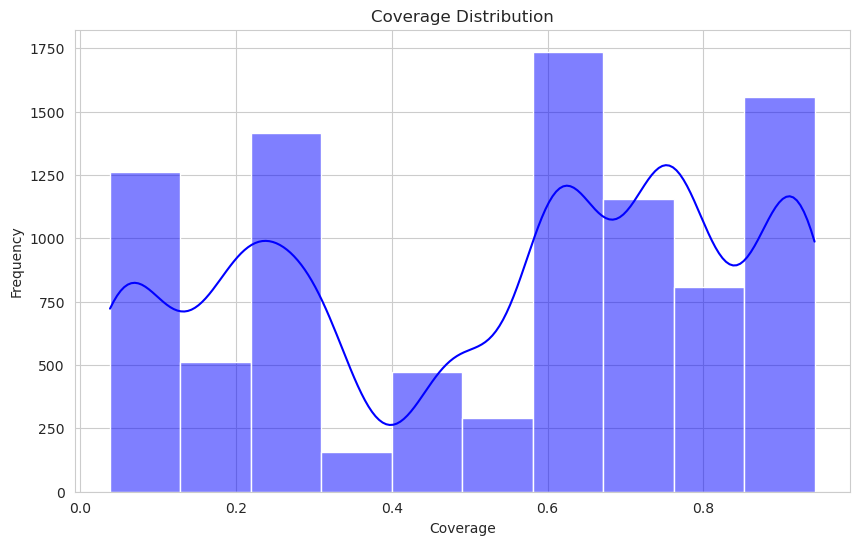

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb

# Style
sb.set_style('whitegrid')

plt.figure(figsize=(10,6))
sb.histplot(data['Coverage'], bins=10, kde=True, color='blue')
plt.title('Coverage Distribution')
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.show()

In [15]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ 0 + C(TargetModule)'
model_spec = formulaic.model_matrix(model_formula, data=data)

#group_idx = pd.Categorical(data['TargetModule']).codes
#group_idx

model_spec.rhs.shape[1]
model_spec.lhs

,Coverage
0,0.666667
1,0.888889
2,0.888889
3,0.666667
4,0.600000
...,...
9355,0.750000
9356,0.869565
9357,0.222222
9358,0.600000


In [16]:
with pm.Model() as model:
    # Priors for the global intercept
    a_bar = pm.Normal('a_bar', mu=0, sigma=1.5)
    
    # Standard deviation across groups
    sigma = pm.Exponential('sigma', 1)
    
    # Group-specific intercepts
    a_m = pm.Normal('a_m', mu=a_bar, sigma=sigma, shape=model_spec.rhs.shape[1])
    
    # Deterministic transformations for logit(pi)
    logit_p = pm.math.dot(model_spec.rhs, a_m)
    
    # Link function - logistic
    p = pm.Deterministic('p', pm.math.sigmoid(logit_p))
    
    # Gamma distribution for theta - dispersion parameter
    theta = pm.Gamma('theta', alpha=2, beta=0.5)  # adjust alpha, beta to reflect your prior knowledge
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Beta('Y_obs', alpha=p*theta, beta=(1-p)*theta, observed=model_spec.lhs['Coverage'])
    
    # Sample from the model
    trace = pm.sample(1000, chains=4, return_inferencedata=True)

print("Model building complete.")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 3 jobs)
NUTS: [a_bar, sigma, a_m, theta]


/home/erik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 67 seconds.


Model building complete.


In [40]:
import arviz as az
column_names = model_spec.rhs.columns
# Iterate over the column names and print out the mapping
for i, name in enumerate(column_names):
    category = name.split('[')[-1].rstrip(']')
    print(f'a_m[{i}]: {category}')


def logit_to_probability(logit_vals):
    """Apply logistic transformation to logit values."""
    return 1 / (1 + np.exp(-logit_vals))


# Create a dictionary for the posterior
posterior_dict = {
    'a_m': trace.posterior['a_m'].values,
    'a_bar': trace.posterior['a_bar'].values,
    'sigma': trace.posterior['sigma'].values
    
}

for key, value in posterior_dict.items():
    posterior_dict[key] = logit_to_probability(value)


posterior_dict['theta'] = trace.posterior['theta'].values

# Create an InferenceData object
infdata = az.from_dict(posterior=posterior_dict)

# Generate a summary table with the mean and 89% HDI for all variables
summary = az.summary(infdata, hdi_prob=0.89)
summary



a_m[0]: T.codetiming._timer
a_m[1]: T.flutils.decorators
a_m[2]: T.flutils.namedtupleutils
a_m[3]: T.flutils.packages
a_m[4]: T.flutils.setuputils.cmd
a_m[5]: T.httpie.output.formatters.headers
a_m[6]: T.httpie.plugins.base
a_m[7]: T.mimesis.builtins.da
a_m[8]: T.py_backwards.transformers.base
a_m[9]: T.py_backwards.transformers.dict_unpacking
a_m[10]: T.py_backwards.transformers.return_from_generator
a_m[11]: T.py_backwards.transformers.yield_from
a_m[12]: T.py_backwards.utils.helpers
a_m[13]: T.pymonet.immutable_list
a_m[14]: T.pymonet.maybe
a_m[15]: T.pymonet.validation
a_m[16]: T.pypara.accounting.journaling
a_m[17]: T.pytutils.lazy.lazy_import
a_m[18]: T.pytutils.python
a_m[19]: T.sanic.config
a_m[20]: T.sanic.helpers
a_m[21]: T.sanic.mixins.signals
a_m[22]: T.thonny.plugins.pgzero_frontend
a_m[23]: T.typesystem.tokenize.positional_validation


,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_m[0],0.873,0.003,0.869,0.877,0.000,0.000,12222.0,2836.0,1.0
a_m[1],0.663,0.004,0.657,0.668,0.000,0.000,10990.0,2883.0,1.0
a_m[2],0.933,0.002,0.930,0.935,0.000,0.000,10530.0,2889.0,1.0
a_m[3],0.052,0.002,0.049,0.054,0.000,0.000,9055.0,2867.0,1.0
a_m[4],0.077,0.002,0.074,0.080,0.000,0.000,11094.0,3096.0,1.0
a_m[5],0.598,0.004,0.592,0.603,0.000,0.000,12113.0,3003.0,1.0
a_m[6],0.747,0.003,0.742,0.753,0.000,0.000,13172.0,2694.0,1.0
a_m[7],0.793,0.003,0.788,0.798,0.000,0.000,13837.0,3021.0,1.0
a_m[8],0.279,0.003,0.273,0.284,0.000,0.000,10633.0,2697.0,1.0
a_m[9],0.140,0.003,0.136,0.144,0.000,0.000,10448.0,2917.0,1.0


array([[<Axes: title={'center': 'a_m_prob'}>,
        <Axes: title={'center': 'a_m_prob'}>]], dtype=object)

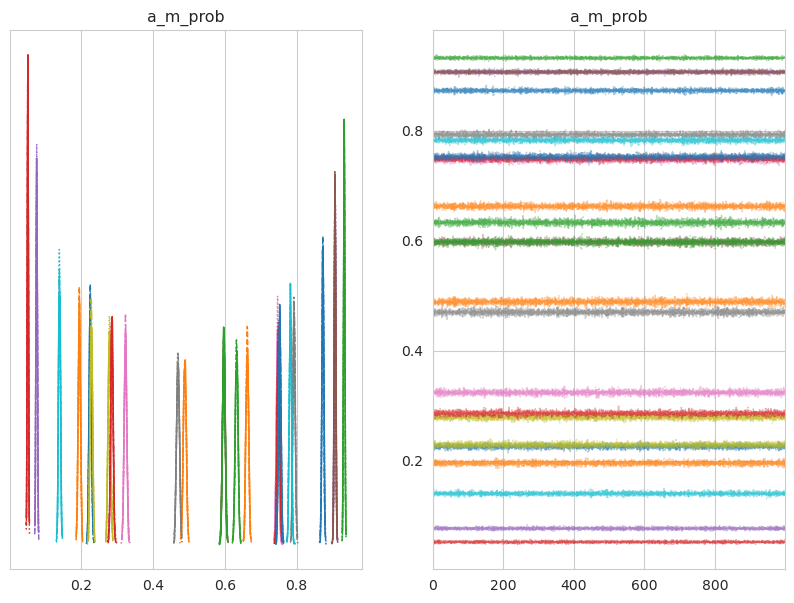

In [29]:
az.plot_trace(posterior_dict, var_names=['a_m_prob'], figsize=(10, 7))

# Data preperation

In [28]:
import pymc as pm
import formulaic
import pandas as pd
import numpy as np

model_formula = 'Coverage ~ C(TargetModule) * C(TuningParameters, Treatment(reference="NONE"))'
model_spec = formulaic.model_matrix(model_formula, data=data)

y = model_spec.lhs
x = model_spec.rhs

In [34]:
with pymc.Model() as model:
    # Priors
    coefs = pymc.Normal('coefs', mu=0, sigma=10, shape=(x.shape[1],))  # One coefficient per predictor
    phi = pymc.Gamma('phi', alpha=2, beta=0.5)  # Precision of the Beta distribution

    # Expected value of outcome
    eta = pymc.math.dot(x, coefs)  # Linear combination of predictors and coefficients
    mu = pymc.math.sigmoid(eta)  # Link function, logistic

    # Likelihood
    Y_obs = pymc.Beta('Y_obs', alpha=mu * phi, beta=(1 - mu) * phi, observed=y['Coverage'])

    # Posterior sampling
    trace = pymc.sample(1000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [coefs, phi]


/home/henrik/miniconda3/envs/analysis_env/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 861 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [35]:
import arviz as az
# Summarize the model outputs

summary = az.summary(trace) #pymc.summary(trace)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coefs[0],1.933,0.063,1.814,2.039,0.014,0.010,20.0,39.0,1.12
coefs[1],-1.261,0.088,-1.420,-1.090,0.016,0.011,32.0,63.0,1.06
coefs[2],0.701,0.123,0.479,0.948,0.018,0.013,46.0,149.0,1.06
coefs[3],-4.746,0.124,-4.978,-4.513,0.015,0.011,66.0,129.0,1.04
coefs[4],-4.430,0.117,-4.648,-4.223,0.019,0.014,37.0,117.0,1.06
...,...,...,...,...,...,...,...,...,...
coefs[308],-0.096,0.143,-0.373,0.167,0.021,0.015,48.0,78.0,1.05
coefs[309],-0.055,0.146,-0.327,0.213,0.021,0.015,50.0,268.0,1.05
coefs[310],-0.053,0.138,-0.307,0.206,0.023,0.016,37.0,114.0,1.06
coefs[311],-0.213,0.136,-0.459,0.042,0.019,0.014,50.0,86.0,1.03


array([[<Axes: title={'center': 'coefs'}>,
        <Axes: title={'center': 'coefs'}>],
       [<Axes: title={'center': 'phi'}>, <Axes: title={'center': 'phi'}>]],
      dtype=object)

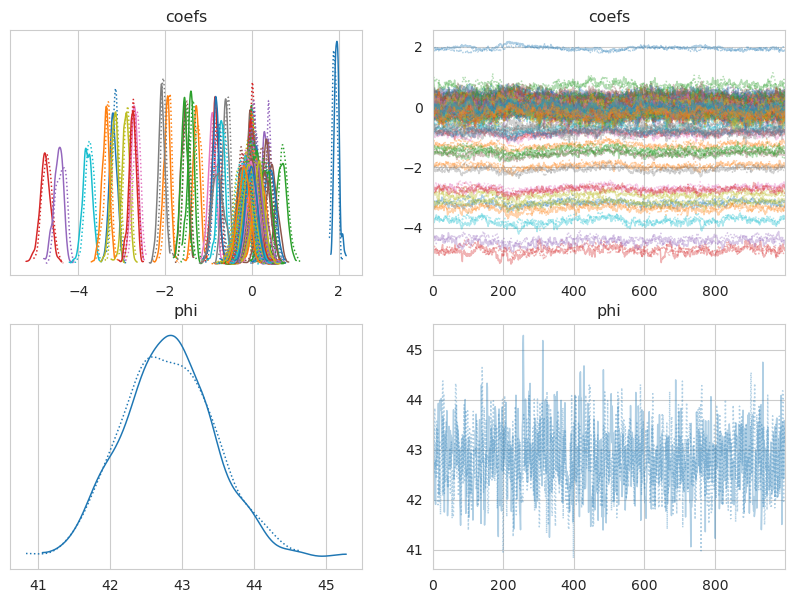

In [36]:
az.plot_trace(trace, figsize=(10, 7))